In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import copy
from typing import Optional

plt.style.use('default')
sns.set()

In [4]:
df_consumption = pd.read_csv('csv_files/realtime_consumption_data.csv')

df_consumption['Tarih'] = pd.to_datetime(df_consumption['Tarih'] + ' ' + df_consumption['hour'], format='%d.%m.%Y %H:%M')
df_consumption = df_consumption.drop('hour', axis=1)

print("Veri seti boyutu:", df_consumption.shape)
print("\nİlk 5 satır:")
print(df_consumption.head())
print("\nVeri seti bilgisi:")
print(df_consumption.info())

Veri seti boyutu: (52632, 2)

İlk 5 satır:
   consumption               Tarih
0     31782.78 2018-12-01 00:00:00
1     30016.48 2018-12-01 01:00:00
2     28713.42 2018-12-01 02:00:00
3     27838.91 2018-12-01 03:00:00
4     27621.64 2018-12-01 04:00:00

Veri seti bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52632 entries, 0 to 52631
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   consumption  52632 non-null  float64       
 1   Tarih        52632 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 822.5 KB
None


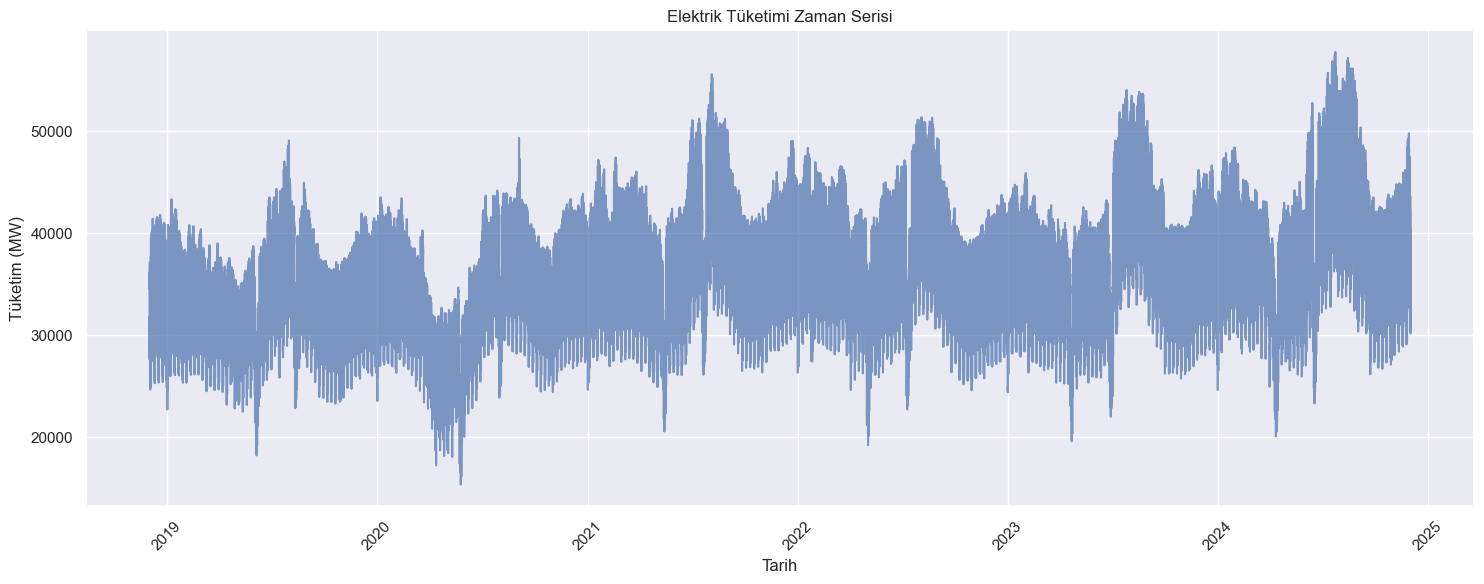

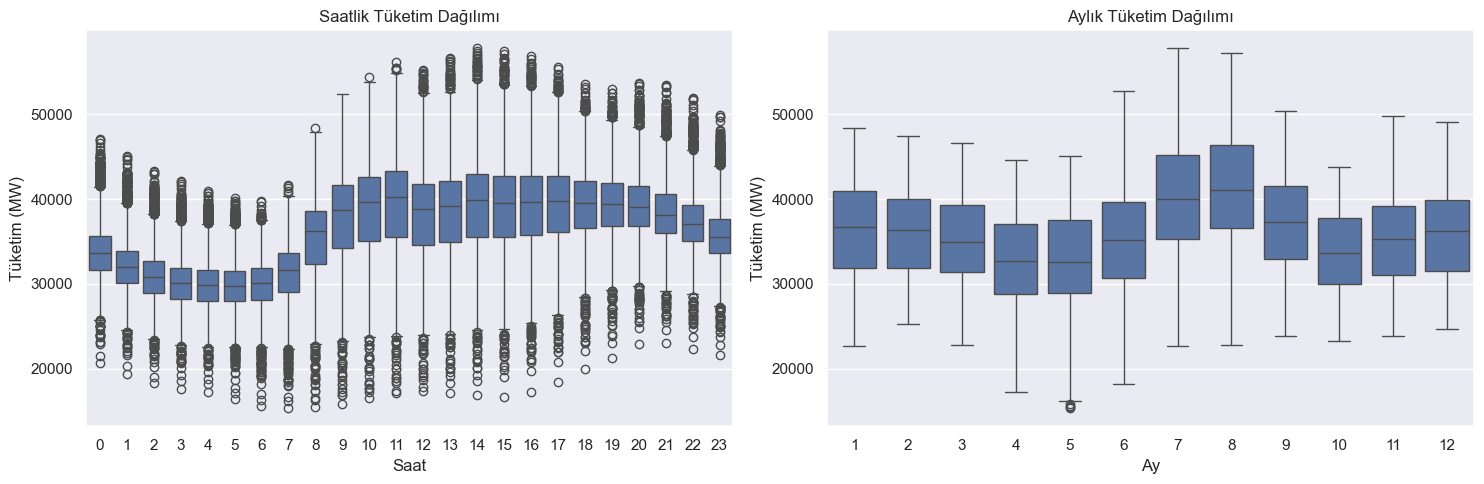

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(df_consumption['Tarih'], df_consumption['consumption'], alpha=0.7)
plt.title('Elektrik Tüketimi Zaman Serisi')
plt.xlabel('Tarih')
plt.ylabel('Tüketim (MW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_consumption['hour'] = df_consumption['Tarih'].dt.hour
df_consumption['day'] = df_consumption['Tarih'].dt.day
df_consumption['month'] = df_consumption['Tarih'].dt.month
df_consumption['year'] = df_consumption['Tarih'].dt.year

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='hour', y='consumption', data=df_consumption, ax=ax1)
ax1.set_title('Saatlik Tüketim Dağılımı')
ax1.set_xlabel('Saat')
ax1.set_ylabel('Tüketim (MW)')

sns.boxplot(x='month', y='consumption', data=df_consumption, ax=ax2)
ax2.set_title('Aylık Tüketim Dağılımı')
ax2.set_xlabel('Ay')
ax2.set_ylabel('Tüketim (MW)')

plt.tight_layout()
plt.show()

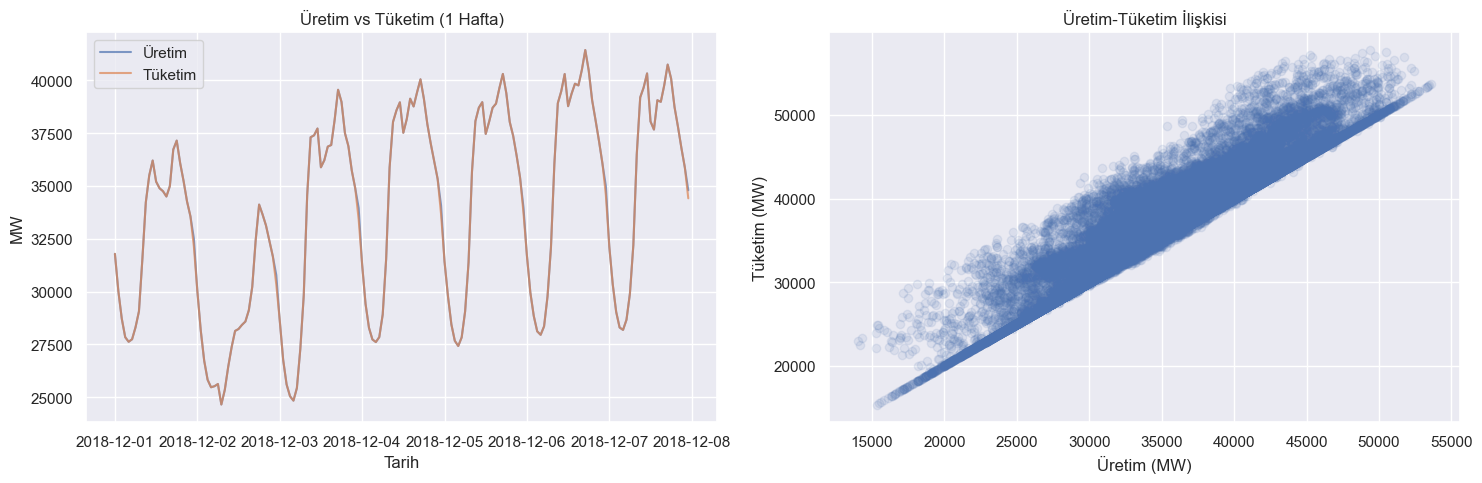


Üretim-Tüketim Korelasyon Katsayısı: 0.9342


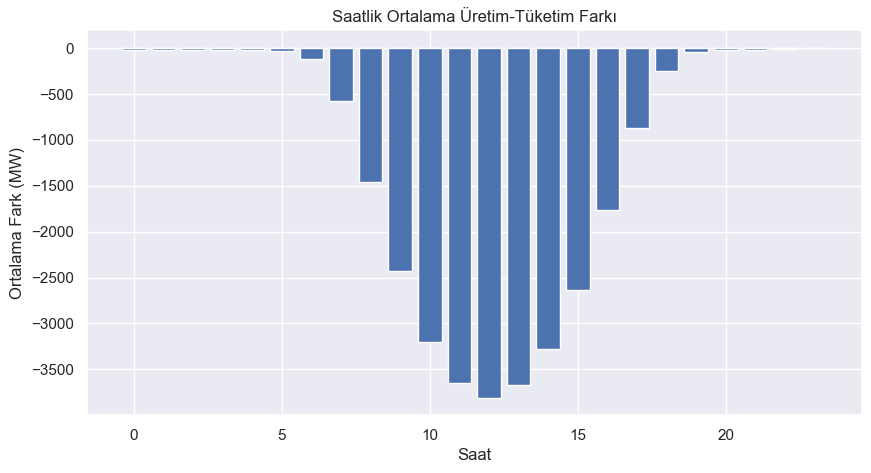

In [6]:
df_production = pd.read_csv('csv_files/realtime_generation_data.csv')

df_production['Tarih'] = pd.to_datetime(df_production['Tarih'] + ' ' + df_production['hour'], format='%d.%m.%Y %H:%M')
df_production = df_production.drop('hour', axis=1)

df = pd.merge(df_consumption, df_production[['Tarih', 'total']], on='Tarih', how='inner')

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(df['Tarih'][:168], df['total'][:168], label='Üretim', alpha=0.7)  
plt.plot(df['Tarih'][:168], df['consumption'][:168], label='Tüketim', alpha=0.7)
plt.title('Üretim vs Tüketim (1 Hafta)')
plt.xlabel('Tarih')
plt.ylabel('MW')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.scatter(df['total'], df['consumption'], alpha=0.1)
plt.xlabel('Üretim (MW)')
plt.ylabel('Tüketim (MW)')
plt.title('Üretim-Tüketim İlişkisi')
plt.grid(True)

plt.tight_layout()
plt.show()

correlation = df['total'].corr(df['consumption'])
print(f"\nÜretim-Tüketim Korelasyon Katsayısı: {correlation:.4f}")

df['difference'] = df['total'] - df['consumption']
hourly_diff = df.groupby(df['Tarih'].dt.hour)['difference'].mean()

plt.figure(figsize=(10, 5))
plt.bar(hourly_diff.index, hourly_diff.values)
plt.title('Saatlik Ortalama Üretim-Tüketim Farkı')
plt.xlabel('Saat')
plt.ylabel('Ortalama Fark (MW)')
plt.grid(True)
plt.show()

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len=24, pred_len=12):
        self.data = torch.FloatTensor(data)
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + self.seq_len:idx + self.seq_len + self.pred_len]
        return x, y

class ConsumptionPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(ConsumptionPredictor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out)
        return predictions

scaler = MinMaxScaler()
production_scaled = scaler.fit_transform(df[['total']]).reshape(-1)
consumption_scaled = scaler.fit_transform(df[['consumption']]).reshape(-1)

seq_len = 24  
pred_len = 12 
batch_size = 32

dataset = TimeSeriesDataset(production_scaled, seq_len, pred_len)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = ConsumptionPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
class ConsumptionPredictor(nn.Module):
    def __init__(self, seq_len=24, pred_len=12, hidden_size=64, num_layers=2):
        super(ConsumptionPredictor, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1
        )
        
        self.fc = nn.Linear(hidden_size, pred_len)  
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]  
        predictions = self.fc(last_hidden)  
        return predictions.unsqueeze(-1)  

model = ConsumptionPredictor(seq_len=24, pred_len=12)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_x.unsqueeze(-1))  
        loss = criterion(outputs, batch_y.unsqueeze(-1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x.unsqueeze(-1))
            test_loss += criterion(outputs, batch_y.unsqueeze(-1)).item()
    
    train_losses.append(epoch_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, '
              f'Test Loss: {test_losses[-1]:.4f}')

Epoch [10/50], Train Loss: 0.0020, Test Loss: 0.0019
Epoch [20/50], Train Loss: 0.0014, Test Loss: 0.0013
Epoch [30/50], Train Loss: 0.0009, Test Loss: 0.0009
Epoch [40/50], Train Loss: 0.0008, Test Loss: 0.0011
Epoch [50/50], Train Loss: 0.0007, Test Loss: 0.0007



Model Performans Metrikleri:
RMSE: 1093.31 MW
MAE: 754.59 MW
R2 Score: 0.9657


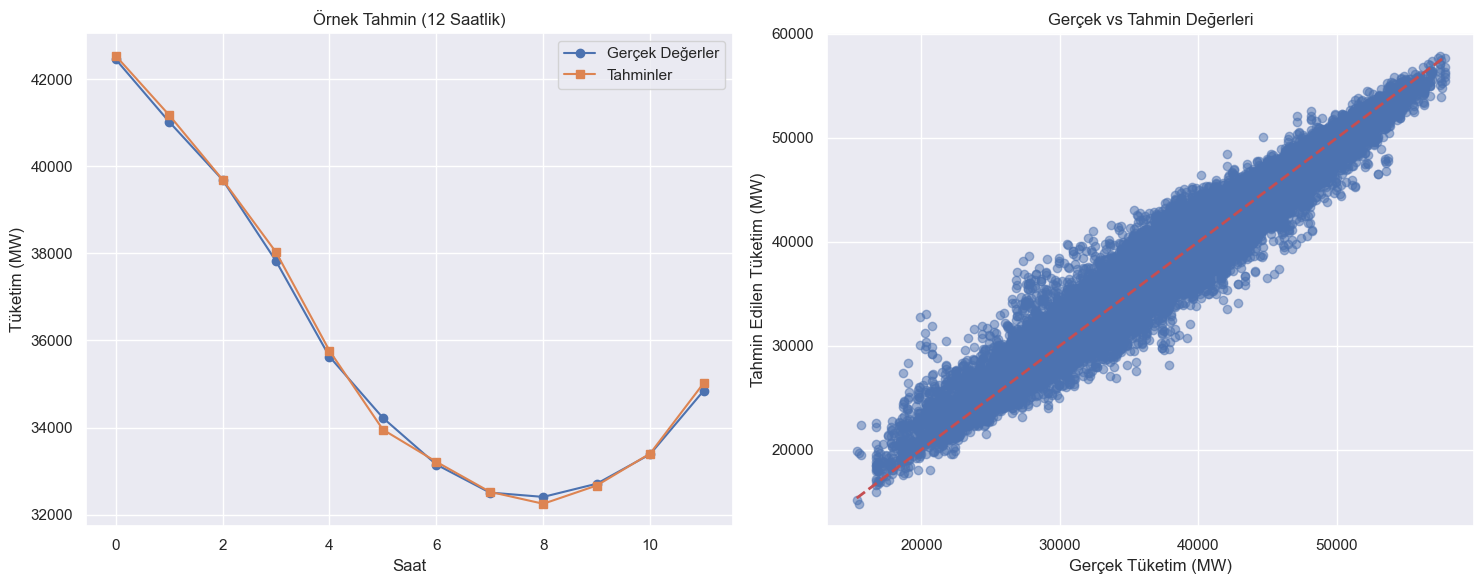

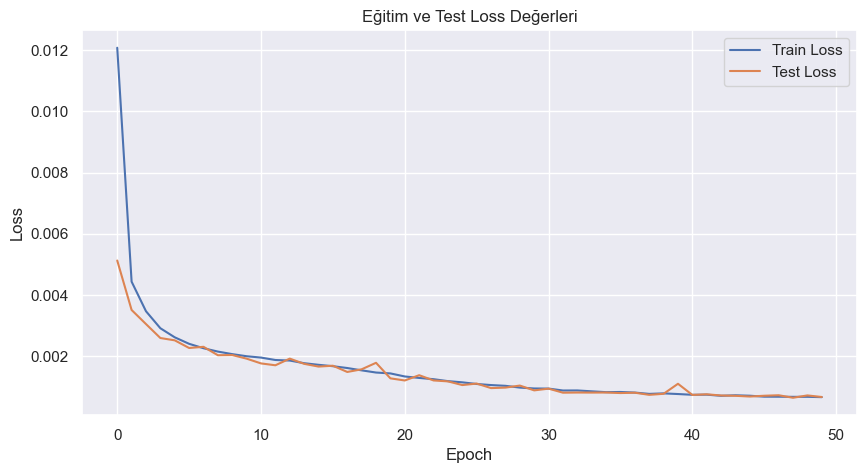


Gelecek 12 Saat için Tüketim Tahmini:
Saat +1: 33689.42 MW
Saat +2: 32551.17 MW
Saat +3: 32222.85 MW
Saat +4: 31960.91 MW
Saat +5: 31004.41 MW
Saat +6: 31573.55 MW
Saat +7: 33808.86 MW
Saat +8: 36550.40 MW
Saat +9: 38973.68 MW
Saat +10: 40264.13 MW
Saat +11: 40018.49 MW
Saat +12: 39656.64 MW


c:\Users\musta\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [11]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x.unsqueeze(-1))
        
        pred = scaler.inverse_transform(outputs.squeeze(-1).numpy())
        actual = scaler.inverse_transform(batch_y.numpy())
        
        predictions.extend(pred)
        actuals.extend(actual)

predictions = np.array(predictions)
actuals = np.array(actuals)

mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals.reshape(-1), predictions.reshape(-1))

print("\nModel Performans Metrikleri:")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAE: {mae:.2f} MW")
print(f"R2 Score: {r2:.4f}")

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(actuals[0][:12], label='Gerçek Değerler', marker='o')
plt.plot(predictions[0][:12], label='Tahminler', marker='s')
plt.title('Örnek Tahmin (12 Saatlik)')
plt.xlabel('Saat')
plt.ylabel('Tüketim (MW)')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.scatter(actuals.reshape(-1), predictions.reshape(-1), alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
plt.title('Gerçek vs Tahmin Değerleri')
plt.xlabel('Gerçek Tüketim (MW)')
plt.ylabel('Tahmin Edilen Tüketim (MW)')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Eğitim ve Test Loss Değerleri')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

def make_prediction(input_sequence):
    model.eval()
    with torch.no_grad():
        scaled_input = scaler.transform(input_sequence.reshape(-1, 1))
        
        x = torch.FloatTensor(scaled_input).view(1, -1, 1)
        
        output = model(x)
        
        prediction = scaler.inverse_transform(output.squeeze().numpy().reshape(-1, 1))
    return prediction

last_24_hours = df['total'].iloc[-24:].values
future_12_hours = make_prediction(last_24_hours)

print("\nGelecek 12 Saat için Tüketim Tahmini:")
for i, pred in enumerate(future_12_hours):
    print(f"Saat +{i+1}: {pred[0]:.2f} MW")

In [15]:
df = pd.read_csv('csv_files/realtime_generation_data.csv')
df_consumption = pd.read_csv('csv_files/realtime_consumption_data.csv')

df['Tarih'] = pd.to_datetime(df['Tarih'] + ' ' + df['hour'], format='%d.%m.%Y %H:%M')
df_consumption['Tarih'] = pd.to_datetime(df_consumption['Tarih'] + ' ' + df_consumption['hour'], format='%d.%m.%Y %H:%M')

df = pd.merge(df, df_consumption[['Tarih', 'consumption']], on='Tarih', how='inner')

def enhance_features(df):
    df = df.copy()
    
    df['hour'] = df['Tarih'].dt.hour
    df['day'] = df['Tarih'].dt.day
    df['month'] = df['Tarih'].dt.month
    df['day_of_week'] = df['Tarih'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    df['lag_24'] = df['total'].shift(24)
    df['lag_168'] = df['total'].shift(168)
    
    df['rolling_mean_24h'] = df['total'].rolling(window=24).mean()
    df['rolling_std_24h'] = df['total'].rolling(window=24).std()
    
    df = df.fillna(method='bfill')
    
    return df

df_enhanced = enhance_features(df)

feature_columns = ['total', 'hour', 'day_of_week', 'is_weekend', 
                  'lag_24', 'lag_168', 'rolling_mean_24h', 'rolling_std_24h']
X = df_enhanced[feature_columns].values
y = df_enhanced['consumption'].values

print("Özellik seti boyutu:", X.shape)
print("\nÖzellikler:", feature_columns)

Özellik seti boyutu: (52632, 8)

Özellikler: ['total', 'hour', 'day_of_week', 'is_weekend', 'lag_24', 'lag_168', 'rolling_mean_24h', 'rolling_std_24h']


C:\Users\musta\AppData\Local\Temp\ipykernel_7088\2336052756.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


In [16]:
class ImprovedConsumptionPredictor(nn.Module):
    def __init__(self, input_size=len(feature_columns), hidden_size=128):
        super(ImprovedConsumptionPredictor, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2,
            bidirectional=True
        )
        
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size*2,
            num_heads=4,
            dropout=0.1
        )
        
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, 12)  
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        out = self.fc1(attn_out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        predictions = self.fc2(out)
        return predictions.unsqueeze(-1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

class EnhancedTimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24, pred_len=12):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.X) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        x = self.X[idx:idx + self.seq_len]
        y = self.y[idx + self.seq_len:idx + self.seq_len + self.pred_len]
        return torch.FloatTensor(x), torch.FloatTensor(y)

dataset = EnhancedTimeSeriesDataset(X_scaled, y_scaled)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

C:\Users\musta\AppData\Local\Temp\ipykernel_7176\2760879371.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
c:\Users\musta\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch [1/50], Train Loss: 0.0198, Val Loss: 0.0032
Epoch [2/50], Train Loss: 0.0052, Val Loss: 0.0022
Epoch [3/50], Train Loss: 0.0039, Val Loss: 0.0019
Epoch [4/50], Train Loss: 0.0031, Val Loss: 0.0015
Epoch [5/50], Train Loss: 0.0024, Val Loss: 0.0013
Epoch [6/50], Train Loss: 0.0021, Val Loss: 0.0016
Epoch [7/50], Train Loss: 0.0019, Val Loss: 0.0012
Epoch [8/50], Train Loss: 0.0018, Val Loss: 0.0013
Epoch [9/50], Train Loss: 0.0017, Val Loss: 0.0011
Epoch [10/50], Train Loss: 0.0017, Val Loss: 0.0011
Epoch [11/50], Train Loss: 0.0016, Val Loss: 0.0011
Epoch [12/50], Train Loss: 0.0016, Val Loss: 0.0011
Epoch [13/50], Train Loss: 0.0016, Val Loss: 0.0010
Epoch [14/50], Train Loss: 0.0015, Val Loss: 0.0010
Epoch [15/50], Train Loss: 0.0015, Val Loss: 0.0010
Epoch [16/50], Train Loss: 0.0014, Val Loss: 0.0010
Epoch [17/50], Train Loss: 0.0014, Val Loss: 0.0009
Epoch [18/50], Train Loss: 0.0014, Val Loss: 0.0009
Epoch [19/50], Train Loss: 0.0014, Val Loss: 0.0009
Epoch [20/50], Train 

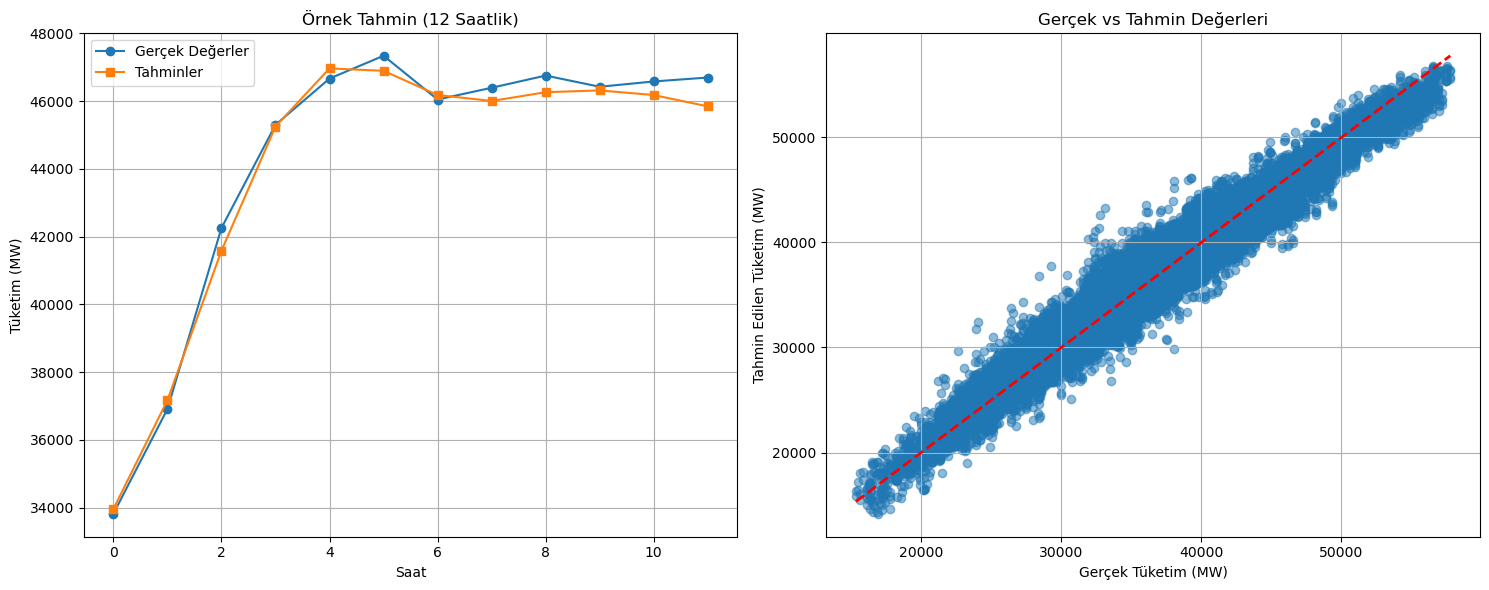

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import copy

df = pd.read_csv('csv_files/realtime_generation_data.csv')
df_consumption = pd.read_csv('csv_files/realtime_consumption_data.csv')

df['Tarih'] = pd.to_datetime(df['Tarih'] + ' ' + df['hour'], format='%d.%m.%Y %H:%M')
df_consumption['Tarih'] = pd.to_datetime(df_consumption['Tarih'] + ' ' + df_consumption['hour'], format='%d.%m.%Y %H:%M')

df = pd.merge(df, df_consumption[['Tarih', 'consumption']], on='Tarih', how='inner')

def enhance_features(df):
    df = df.copy()
    
    df['hour'] = df['Tarih'].dt.hour
    df['day'] = df['Tarih'].dt.day
    df['month'] = df['Tarih'].dt.month
    df['day_of_week'] = df['Tarih'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    df['lag_24'] = df['total'].shift(24)
    df['lag_168'] = df['total'].shift(168)
    
    df['rolling_mean_24h'] = df['total'].rolling(window=24).mean()
    df['rolling_std_24h'] = df['total'].rolling(window=24).std()
    
    df = df.fillna(method='bfill')
    
    return df

df_enhanced = enhance_features(df)

feature_columns = ['total', 'hour', 'day_of_week', 'is_weekend', 
                  'lag_24', 'lag_168', 'rolling_mean_24h', 'rolling_std_24h']
X = df_enhanced[feature_columns].values
y = df_enhanced['consumption'].values

class EnhancedTimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24, pred_len=12):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.X) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        x = self.X[idx:idx + self.seq_len]
        y = self.y[idx + self.seq_len:idx + self.seq_len + self.pred_len]
        return torch.FloatTensor(x), torch.FloatTensor(y)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

dataset = EnhancedTimeSeriesDataset(X_scaled, y_scaled)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class ImprovedConsumptionPredictor(nn.Module):
    def __init__(self, input_size=len(feature_columns), hidden_size=64):
        super(ImprovedConsumptionPredictor, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0.1,
            bidirectional=False
        )
        
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(32, 12)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc1(lstm_out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        predictions = self.fc2(out)
        return predictions.unsqueeze(-1)

class EarlyStopping:
    def __init__(self, patience: int = 7, min_delta: float = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss: float) -> None:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

model = ImprovedConsumptionPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

early_stopping = EarlyStopping(patience=10)

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            val_loss += criterion(outputs, batch_y).item()
    
    scheduler.step(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Erken durdurma!")
        break

model = best_model
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        pred = outputs.squeeze(-1).numpy() 
        actual = batch_y.numpy()  
        
        for i in range(pred.shape[0]):  
            pred_scaled = scaler_y.inverse_transform(pred[i].reshape(-1, 1)).reshape(-1)
            actual_scaled = scaler_y.inverse_transform(actual[i].reshape(-1, 1)).reshape(-1)
            
            predictions.append(pred_scaled)
            actuals.append(actual_scaled)

predictions = np.array(predictions)
actuals = np.array(actuals)

mse = mean_squared_error(actuals.reshape(-1), predictions.reshape(-1))
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals.reshape(-1), predictions.reshape(-1))
r2 = r2_score(actuals.reshape(-1), predictions.reshape(-1))

print("\nModel Performans Metrikleri:")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAE: {mae:.2f} MW")
print(f"R2 Score: {r2:.4f}")

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(actuals[0], label='Gerçek Değerler', marker='o')
plt.plot(predictions[0], label='Tahminler', marker='s')
plt.title('Örnek Tahmin (12 Saatlik)')
plt.xlabel('Saat')
plt.ylabel('Tüketim (MW)')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.scatter(actuals.reshape(-1), predictions.reshape(-1), alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
plt.title('Gerçek vs Tahmin Değerleri')
plt.xlabel('Gerçek Tüketim (MW)')
plt.ylabel('Tahmin Edilen Tüketim (MW)')
plt.grid(True)

plt.tight_layout()
plt.show()